### Custom Data Scraping Project.

This project aims to:

- scrape content from news website 'https://bbc.com/news'
- Due to time it can take to load and scrape all artiles,Read first 20 Articles appearing on the News front page.
- Extracting the content of each article: Each article has Title Headline, Author, Image, Article Description, List of Tags at the end of the news article. Image will not be part of the extracted content
- Keeping all data about the articles in csv file for later analysis.
- Sentiment Analysis of the news content.How many polarities (postives, neutral and negatives) and Average subjectivities of the news content. Showing the graph of sentiment analysis on the BBC news content

- Extracting the most occuring 10 words from news content.
- Counting how many two keywords : 'Israel' and 'Iran' Are appearing together with their frequency bar chart.

- Knowing How many times Each News' Tag has appeared in all articles.

- Who are top three Authors who wrote many articles?

Requirements:
 - seaborn
 - Selenium 

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import random

**!. Selecting (Python 3.X) as kernel**

In [ ]:
def scrape_bbc_news():
    # Set up the Chrome driver path
    driver_path = './chromedriver-win64/chromedriver.exe'
    bbc_news_url = 'https://www.bbc.com/news'

    # Set Chrome options for the webdriver
    options = webdriver.ChromeOptions()
    
    # Start a new Chrome session
    service = Service(driver_path)
    driver = webdriver.Chrome(service=service, options=options)
    driver.get(bbc_news_url)

    # Wait for the page to load
    time.sleep(random.uniform(6, 10))

    # XPath to locate all article links on the main page
    article_xpath = '//a[contains(@href, "/news/articles/") and @class="sc-2e6baa30-0 gILusN"]'
    news_titles, article_authors, article_descriptions, article_tags = [], [], [], []

    # Function to scroll down to load more articles
    def scroll_down():
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(random.uniform(3, 6))

    try:
        # Collecting article links from the main page
        article_links = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.XPATH, article_xpath))
        )
        
        for article in article_links[:20]:  # Limiting to the first 20 articles for sake of time.
            # Opening the article in a new tab
            driver.execute_script("window.open(arguments[0]);", article.get_attribute("href"))
            driver.switch_to.window(driver.window_handles[1])

            # Waiting for the elements to load and extract data
            try:
                title = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, '//h1'))
                ).text

                try:
                    detailed_page_author_Xpath='//div[@data-testid="byline-new-contributors"]//span[@class="sc-2b5e3b35-7 bZCrck"]' 
                    author = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.XPATH, detailed_page_author_Xpath))
                    ).text
                except:
                    author = "Unknown"  # In case the author is not found

                description_elements = driver.find_elements(By.XPATH, '//p')
                description = ' '.join([desc.text for desc in description_elements if desc.text])

                detailed_page_tags_Xpath ='//div[@data-component="tags"]//a'
                tag_elements = driver.find_elements(By.XPATH, detailed_page_tags_Xpath)
                tags = ', '.join([tag.text for tag in tag_elements if tag.text])

                # Append data to lists
                news_titles.append(title)
                article_authors.append(author)
                article_descriptions.append(description)
                article_tags.append(tags)

            except Exception as e:
                print(f"Error extracting data for an article: {e}")
            finally:
                driver.close()
                driver.switch_to.window(driver.window_handles[0])

    except Exception as e:
        print(f"Error loading articles: {e}")

    finally:
        driver.quit()

    # Save the collected data to a CSV file
    news_df = pd.DataFrame({
        'Title': news_titles,
        'Author': article_authors,
        'Description': article_descriptions,
        'Tags': article_tags
    })

    if not news_df.empty:
        news_df.to_csv('bbc_news.csv', index=False)
        print("Data saved successfully to bbc_news.csv")
    else:
        print("No data to save.")

if __name__ == '__main__':
    scrape_bbc_news()


#### Data Analysis on the 'bbc_news.csv'

In [3]:
## laoding the data frame

bbc_news_df = pd.read_csv('bbc_news.csv')
bbc_news_df.head()
        

,Title,Author,Description,Tags
0,What is Unrwa and why has Israel banned it?,Unknown,Israel's parliament voted on Monday evening to...,"Middle East, Israel & the Palestinians, Israel..."
1,"Teri Garr, Young Frankenstein and Tootsie star...",Rachel Looker,"Teri Garr, an Oscar-nominated actress best kno...",United States
2,Orban swipes at EU and says disputed Georgian ...,Paul Kirby,Hungary's Viktor Orban congratulated Georgia's...,"Georgia, European Union, Hungary"
3,Shawn Mendes says he's 'just figuring out' sex...,Ana Faguy,Singer Shawn Mendes opened up about his sexual...,"Canada, Music"
4,What is Unrwa and why has Israel banned it?,Unknown,Israel's parliament voted on Monday evening to...,"Middle East, Israel & the Palestinians, Israel..."


**1. Most 10 occuring words in the news content | Title & Description**

**2. Occurence of two keywords**

**3. Occurence/Frequency of Tags**

**4. Top 3 Authors**


10 most occuring words in the articles

said: 140
Israel: 88
BBC: 67
Israeli: 58
Gaza: 58
people: 52
Unrwa: 50
site: 46
also: 40
US: 40

Frequency of tags in the articles

Georgia: 1
Canada: 1
Media: 1
Japan: 1
Nigeria: 1
Argentina: 1
Israel: 1

Top 3 most occuring authors



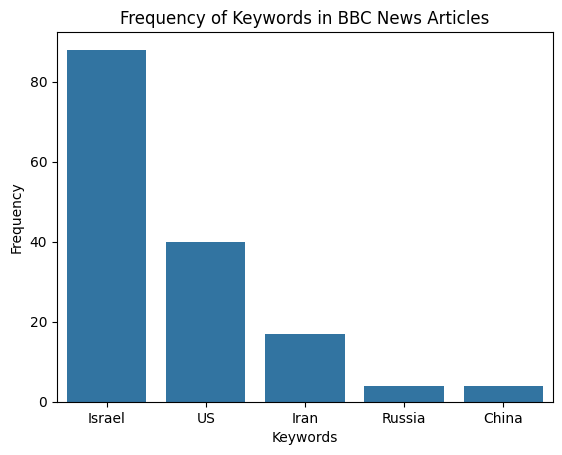

In [25]:
###
 # 10 most occuring words in both description column and title

import nltk
from nltk.corpus import stopwords
import seaborn as sns
from textblob import TextBlob


class TextProcessing:
    def __init__(self, df):
        self.df = df
        self.stop_words = set(stopwords.words('english'))


    def handle_stopwords(self):
        try:
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('stopwords')

    def most_10_occuring_words(self):
        self.handle_stopwords()
        # Load the stopwords
        word_counts = {}

        self.df['Combined'] = self.df['Title'] + ' ' + self.df['Description']

        for sentence in self.df['Combined'].str.split():
            for word in sentence:
                word = word.strip('.,()/>\\<:-+@?"\'|,%$*=#^[]{}&!~`;_')

                if word.lower() not in self.stop_words and word.isalpha() and len(word) > 1:
                    if word in word_counts:
                        word_counts[word] += 1
                    else:
                        word_counts[word] = 1

        # sometimes, the words like Israel, Israel's, Israeli must be considered as same word

        for word in list(word_counts.keys()):
            if word + 's' in word_counts:
                word_counts[word] += word_counts[word + 's']
                del word_counts[word + 's']

            elif word + 'es' in word_counts:
                word_counts[word] += word_counts[word + 'es']
                del word_counts[word + 'es']
            
            elif word + 'ed' in word_counts:
                word_counts[word] += word_counts[word + 'ed']
                del word_counts[word + 'ed']

            elif word + 'ing' in word_counts:
                word_counts[word] += word_counts[word + 'ing']
                del word_counts[word + 'ing']

            elif word[:len(word)-1] == word[:len(word)]:
                word_counts[word] += word_counts[word[:len(word)-1]]
                del word_counts[word[:len(word)-1]]

            # handel irregular verbs like say, said, says
            elif word == 'said':
                word_counts[word] += word_counts['says']
                del word_counts['says']
               


        # Sort the dictionary by values in descending order
        sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

        for word, count in sorted_word_counts:
            print(f"{word}: {count}")


    
    def keywords_frequency(self,keyword_list):
        self.handle_stopwords()

        keyword_counts = {}
        self.df['Combined'] = self.df['Title'] + ' ' + self.df['Description']

        for sentence in self.df['Combined'].str.split():
            for word in sentence:
                word = word.strip('.,()/>\\<:-+@?"\'|,%$*=#^[]{}&!~`;_')

                if word.lower() not in self.stop_words and word.isalpha() and len(word) > 1:
                    if len(keyword_list) >5:
                        print("Please provide only atmost 5 keywords")
                        break
                    if word in keyword_list:
                        if word in keyword_counts:
                            keyword_counts[word] += 1
                        else:
                            keyword_counts[word] = 1


            # plotting the occurence of each keyword on bargraph
        bar_plot=sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
        bar_plot.set(xlabel='Keywords', ylabel='Frequency')
        bar_plot.set_title('Frequency of Keywords in BBC News Articles')
        return bar_plot
    


    def tags_frequency(self):
        self.handle_stopwords()
        tag_counts = {}
        for tags in self.df['Tags'].str.split(','):
                for tag in tags:
                    tag = tag.strip('.,()/>\\<:-+@?"\'|,%$*=#^[]{}&!~`;_')

                    if tag.lower() not in self.stop_words and tag.isalpha() and len(tag) > 1:
                        if tag in tag_counts:
                            tag_counts[tag] += 1
                        else:
                            tag_counts[tag] = 1

        # Sort the dictionary by values in descending order
        sorted_tag_counts = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

        for tag, count in sorted_tag_counts:
            print(f"{tag}: {count}")


    def top_3_most_occuring_authors(self):
        author_counts = {}
        for author in self.df['Author']:
            author = author.strip('.,()/>\\<:-+@?"\'|,%$*=#^[]{}&!~`;_')

            if author.lower() not in self.stop_words and author.isalpha() and len(author) > 1 and author != 'Unknown':
                if author in author_counts:
                    author_counts[author] += 1
                else:
                    author_counts[author] = 1

        # Sort the dictionary by values in descending order
        sorted_author_counts = sorted(author_counts.items(), key=lambda x: x[1], reverse=True)[:3]

        for author, count in sorted_author_counts:
            print(f"{author} is occuring: {count} times")


if __name__ == '__main__':
    #1. 10 most occuring words in both description column and title
    print("\n====================================\n10 most occuring words in the articles\n====================================\n")
    tp = TextProcessing(bbc_news_df)
    tp.most_10_occuring_words()


    #2. Frequency of keywords in the articles
    keywords=['Iran','Israel','US','China','Russia']
    tp.keywords_frequency(keywords)


    # 3. Frequency of tags in the articles
    print("\n===============================\nFrequency of tags in the articles\n===============================\n")
    tp.tags_frequency()


    # 4. Top 3 most occuring authors
    print("\n====================================\nTop 3 most occuring authors\n====================================\n")
    tp.top_3_most_occuring_authors()



**5. Sentiment Analysis**


Sentiment analysis of the articles

Postive polarities: 16
Negative polarities: 4
Neutral polarities: 0
Averge subjectivity: 0.3626


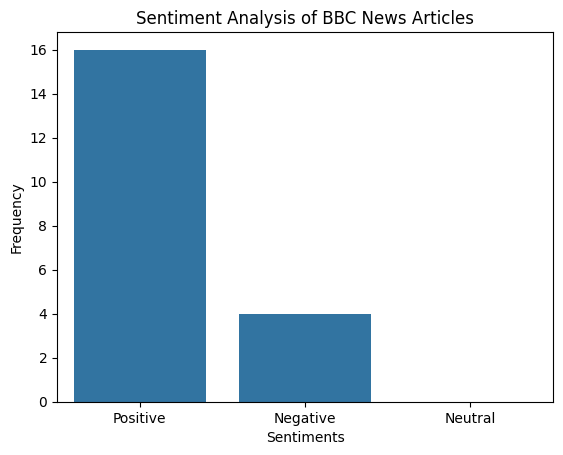

In [28]:
class Sentiment_Analysis(TextProcessing):

    def handle_sentiment_analyis(self):
        postive_polarities=0
        negative_polarities=0
        neutral_polarities=0
        subjectivity=0

        for sentence in self.df['Combined']:
            blob = TextBlob(sentence)
            if blob.polarity > 0:
                postive_polarities+=1
            elif blob.polarity < 0:
                negative_polarities+=1
            else:
                neutral_polarities+=1
            subjectivity+=blob.subjectivity


        print(f"Postive polarities: {postive_polarities}")
        print(f"Negative polarities: {negative_polarities}")
        print(f"Neutral polarities: {neutral_polarities}")
        print(f'Averge subjectivity: {(subjectivity/len(self.df['Combined'].str.split())):.4f}')


        #ploting the sentiment analysis
        sentiment_plot=sns.barplot(x=['Positive','Negative','Neutral'], y=[postive_polarities,negative_polarities,neutral_polarities])
        sentiment_plot.set(xlabel='Sentiments', ylabel='Frequency')
        sentiment_plot.set_title('Sentiment Analysis of BBC News Articles')
        return sentiment_plot
        
           



if __name__ == '__main__':
    
    # 5. Sentiment analysis of the articles
    print("\n====================================\nSentiment analysis of the articles\n====================================\n")
    Sentiment_Analysis(bbc_news_df).handle_sentiment_analyis()
    